In [2]:
import re
import os
import time
import pickle
import sklearn
#import cx_Oracle
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.sparse
from tqdm import tqdm
from sklearn import datasets
from collections import defaultdict
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix, coo_matrix, csc_matrix


# oracle
#oracle_user = "ro_user"
#oracle_pass = "ro_user"
#oracle_scheme = "aml_evraz"
#oracle_host = "192.168.101.13/rnd"
#oracle_connection = cx_Oracle.connect(oracle_user, oracle_pass, oracle_host, encoding = "UTF-8", nencoding = "UTF-8")
#oracle_cursor = oracle_connection.cursor()

### PUT YOUR PATH HERE (mine default is home/username/notebooks)
path_to_data = '../../shared_files/'

%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

### Timer, table stat function, P_CLIENTID clearing procedure, function for flattening dataframe by cat column

In [3]:
class Timer:
    def __init__(self, msg='operation', verbose=True):
        self.msg = msg
        self.verbose = verbose       
    def __enter__(self, ):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        if self.verbose:
            print('{} took {:.3f}s'.format(self.msg, self.interval), flush=True)


def df_categorical_variables_stat(df, max_cardinality=200):
    for colname in df.columns:
        print('next_column: {}'.format(colname))
        uniq_vals = df[colname].unique()
        nunique = len(uniq_vals)
        print("# of uniqs: {}".format(nunique))
        if nunique < max_cardinality:
            print('Viable Categorical. Value counts:')
            print(df[colname].value_counts(dropna=False))
        else:
            print('High cardinality/Non categorical')
        print((('-' * 80) + '\n')*3)


def process_client_indices(client_indices, trivial_to_nontrivial=None, default_null=-1000):
    if trivial_to_nontrivial is None:
        trivial_ids_to_nontrivial = defaultdict(lambda: -len(trivial_ids_to_nontrivial) - 2)

    nontrivial_clients_ids = client_indices.copy()
    nontrivial_clients_ids[nontrivial_clients_ids.isnull()] = default_null

    nontrivial_clients_ids = nontrivial_clients_ids.map(str)

    nontrivial_ids = nontrivial_clients_ids.map(lambda s: s.strip())

    is_trivial = nontrivial_ids.map(lambda s: len(re.findall('^([\d]+|-[\d]+)', s)) == 0)
    trivial_ids = nontrivial_ids[is_trivial]

    for ti in trivial_ids:
        trivial_ids_to_nontrivial[ti]
    trivial_ids_to_nontrivial
    nontrivial_ids[is_trivial] = trivial_ids.map(lambda s: str(trivial_ids_to_nontrivial[s]))

    nontrivial_ids = nontrivial_ids.map(lambda s: re.findall('^([\d]+|-[\d]+)', s)[0]).map(int)
    return nontrivial_ids, trivial_to_nontrivial


def flatten_by_column(df, to_flatten, flatten_by, group_by, names_flatten_by=None):
    if names_flatten_by is None:
        names_flatten_by = {
            uniq_val: '{}={}'.format(flatten_by, uniq_val)
            for uniq_val in df[flatten_by].unique()
        }
    #column_to_flatten_by = 'P_CLIENTROLE'
    #column_to_group_by = 'P_SUSPICIOUSOPERATIONID'
    #column_to_flatten = 'P_CLIENTID'
    column_to_flatten_by = flatten_by
    column_to_flatten = to_flatten
    column_to_group_by = group_by
    frames_to_join = [
        df[[column_to_group_by, column_to_flatten]][df[column_to_flatten_by] == uniq_val]
        for uniq_val in df[column_to_flatten_by].unique()
    ]

    for frame, uniq_val in zip(frames_to_join, df[flatten_by].unique()):
        frame.rename(columns={column_to_flatten: names_flatten_by[uniq_val]}, inplace=True)
        frame.set_index(column_to_group_by, inplace=True)

    res = frames_to_join[0].join(frames_to_join[1:], how='outer')
    return res


def flatten_df_by_column(df, to_flatten, flatten_by, group_by, names_flatten_by=None):
    if names_flatten_by is None:
        names_flatten_by = {
            uniq_val: '{}={}'.format(flatten_by, uniq_val)
            for uniq_val in df[flatten_by].unique()
        }
    #column_to_flatten_by = 'P_CLIENTROLE'
    #column_to_group_by = 'P_SUSPICIOUSOPERATIONID'
    #column_to_flatten = 'P_CLIENTID'
    column_to_flatten_by = flatten_by
    columns_to_flatten = to_flatten
    if not isinstance(columns_to_flatten, (list, tuple, pd.Index)):
        columns_to_flatten = [to_flatten]
    column_to_group_by = group_by
    frames_to_join = [
        df[[column_to_group_by] + columns_to_flatten][df[column_to_flatten_by] == uniq_val]
        for uniq_val in df[column_to_flatten_by].unique()
    ]

    for frame, uniq_val in zip(frames_to_join, df[flatten_by].unique()):
        frame.rename(
            columns = {
                column_to_flatten: '{}__{}'.format(column_to_flatten, names_flatten_by[uniq_val])
                for column_to_flatten in columns_to_flatten
            },
            inplace=True)
        frame.set_index(column_to_group_by, inplace=True)

    res = frames_to_join[0].join(frames_to_join[1:], how='outer')
    return res


def join_ops_with_flatten_members(ops, flatten_ops_with_members, id_colname='ID'):
    ops_to_join = ops.set_index(id_colname, drop=False)
    joined_ops = ops_to_join.join(flatten_ops_with_members, how='left')
    joined_ops.reset_index(drop=True, inplace=True)
    return joined_ops

### Read tables from csv, drop 

In [4]:
%reset_selective -f susp_ops
%reset_selective -f susp_members
%reset_selective -f off_ops
%reset_selective -f off_members

with Timer('read susp_ops', True):
    susp_ops = pd.read_csv(os.path.join(path_to_data, 'susp_ops.csv'))
with Timer('read susp_members', True):
    susp_members = pd.read_csv(os.path.join(path_to_data, 'susp_members.csv'))
with Timer('read off_ops', True):
    off_ops = pd.read_csv(os.path.join(path_to_data, 'off_ops.csv'))
with Timer('read off_ops', True):
    off_members = pd.read_csv(os.path.join(path_to_data, 'off_members.csv'))
    
with Timer('drop messy off_members columns'):
    off_members.drop(['P_DATE_INSERT', 'P_DATE_UPDATE', 'CHANGEDATE'], axis=1, inplace=True)

/home/const.belev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,9,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


read susp_ops took 8.114s


/home/const.belev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


read susp_members took 7.510s


/home/const.belev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,8,9,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


read off_ops took 84.315s


/home/const.belev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,5,11,17,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


read off_ops took 80.878s
drop messy off_members columns took 3.058s


### use only members linked to existing P_OPERATIONIDs

In [5]:
off_members, _off_members = off_members[off_members.P_OPERATIONID.isin(off_ops.ID)].copy(), off_members

%reset_selective -f _off_members

### Clean mess with P_CLIENTID and columns containing nans

In [7]:
fill_values_for_off_members = {
    'P_BSCLIENTID': -1000,
    'P_REGOPENDATE': '0000-00-00 00:00:00',
    'P_BSACCOUNT': -1000,
    'P_BANK': 'UNKNOWN',
    'P_SDP': -1000,
    'P_ORGFORM': -1000,
    'P_BANKCITY': 'UNKNOWN'
}

with Timer('filling NaNs in off_members'):
    off_members.fillna(value=fill_values_for_off_members, inplace=True)

filling NaNs in off_members took 2.833s


In [8]:
with Timer('off_members client_ids processing'):
    off_members.loc[:, 'P_CLIENTID'], trivial_ids_to_nontrivial = process_client_indices(off_members.P_CLIENTID)

off_members client_ids processing took 51.321s


In [20]:
with Timer('dropping duplicate rows from off_members'):
    off_members.drop_duplicates(off_members.columns.drop(['ID', 'P_BSCLIENTID', 'P_BSACCOUNT']), inplace=True)

dropping duplicate rows from off_members took 37.145s


### Convert time to datetime format and sort operations by time

In [25]:
with Timer('process off_ops', True):
    off_ops.loc[:, 'P_OPERATIONDATETIME'] = pd.to_datetime(off_ops['P_OPERATIONDATETIME'])
    off_ops.sort_values(by='P_OPERATIONDATETIME', kind='mergesort', inplace=True)

process off_ops took 8.471s


### Get some meaningful columns from off_members

In [28]:
%reset_selective -f p_regopendate
%reset_selective -f p_countrycode
%reset_selective -f p_bankcity
%reset_selective -f p_bank
%reset_selective -f p_sdp
%reset_selective -f p_bank_client
%reset_selective -f p_client_type
%reset_selective -f p_clientrole
%reset_selective -f countrycode_counts
%reset_selective -f bank_counts



def dat_mapper(dat):
    if isinstance(dat, str):
        if '0.1.1-01 00:00:00' in dat:
            return np.nan
        elif '0.1.1-01 00:00:' in dat:
            return np.nan
        elif '0001-01-01 00:00:00' in dat:
            return '2001-01-01 00:00:00'
        else:
            return dat
    return dat

with Timer('process selected fields from off_members'):
    # There are some weird dates in P_REGOPENDATE, dat_mapper will clear em
    p_regopendate = pd.to_datetime(off_members.P_REGOPENDATE, errors='coerce', format='%Y-%m-%d %H:%M:%S')

    # Rare countrycodes would be set as 'UNFREQ', NaNs will be 'UNKNOWN'
    p_countrycode = off_members.P_COUNTRYCODE.copy()
    countrycode_counts = p_countrycode.value_counts()
    p_countrycode[p_countrycode.isin(countrycode_counts[countrycode_counts <= 100].index)] = 'UNFREQ'
    p_countrycode[p_countrycode.isnull()] = 'UNKNOWN'

    # Same for bankcity
    p_bankcity = off_members.P_BANKCITY.copy()
    bankcity_counts = p_bankcity.value_counts()
    p_bankcity[p_bankcity.isin(bankcity_counts[bankcity_counts <= 100].index)] = 'UNFREQ'
    p_bankcity[p_bankcity.isnull()] = 'UNKNOWN'

    # for bank there is only a few NaN values, so it will be 'UNFREQ' aswell
    p_bank = off_members.P_BANK.copy()
    bank_counts = p_bank.value_counts()
    p_bank[p_bank.isin(bank_counts[bank_counts <= 100].index)] = 'UNFREQ'
    p_bank[p_bank.isnull()] = 'UNFREQ'

    # SDP nas only NaN/13.0 values, so simply encode NaN with -1k
    p_sdp = off_members.P_SDP.copy()
    p_sdp[p_sdp.isnull()] = -1000

    # No missing values
    p_bank_client = off_members.P_BANK_CLIENT.copy()

    # No missing values
    p_client_type = off_members.P_CLIENT_TYPE.copy()

    # No missing values
    p_clientrole = off_members.P_CLIENTROLE.copy()

process selected fields from off_members took 21.492s


### Build new member info dataframe on top of processed columns

In [29]:
%reset_selective -f off_members_selected

off_members_selected = off_members[['P_CLIENTID', 'P_OPERATIONID']].copy()
off_members_selected['P_REGOPENDATE'] = p_regopendate
off_members_selected['P_COUNTRYCODE'] = p_countrycode
off_members_selected['P_BANKCITY'] = p_bankcity
off_members_selected['P_BANK'] = p_bank
off_members_selected['P_BANK_CLIENT'] = p_bank_client
off_members_selected['P_CLIENT_TYPE'] = p_client_type
off_members_selected['P_CLIENTROLE'] = p_clientrole

off_members_selected.head(5)

,P_CLIENTID,P_OPERATIONID,P_REGOPENDATE,P_COUNTRYCODE,P_BANKCITY,P_BANK,P_BANK_CLIENT,P_CLIENT_TYPE,P_CLIENTROLE
0,950240000112,529719567,NaT,KZ,АЛМАТЫ,190501948,2,3,1
1,950240000112,529719567,2003-09-02,KZ,АЛМАТЫ,EURIKZKA,2,1,2
2,950240000112,529722750,2003-09-02,KZ,АЛМАТЫ,190501948,2,1,1
3,950240000112,529722750,2003-09-02,KZ,АЛМАТЫ,EURIKZKA,2,1,2
4,950240000112,529722753,NaT,KZ,АЛМАТЫ,190501948,2,3,1


### Now its time to flatten selected members grouped by P_OPERATIONID, based on a P_CLIENTROLE

In [30]:
%reset_selective -f selected_members_flatten

names_by_clientrole = {
    1: 'source_role',
    2: 'target_role',
    3: 'id_susp_3',
    4: 'id_susp_4',
    5: 'beneficial_role',
    6: 'id_susp_6'
}

with Timer('building flatten selected members'):
    selected_members_flatten = flatten_df_by_column(
        off_members_selected,
        to_flatten=[
           'P_CLIENTID',
           'P_REGOPENDATE',
           'P_COUNTRYCODE',
           'P_BANKCITY',
           'P_BANK',
           'P_BANK_CLIENT',
           'P_CLIENT_TYPE'],
        flatten_by='P_CLIENTROLE',
        group_by='P_OPERATIONID',
        names_flatten_by=names_by_clientrole)

building flatten selected members took 17.950s


In [31]:
selected_members_flatten.columns

Index(['P_CLIENTID|sender', 'P_REGOPENDATE|sender', 'P_COUNTRYCODE|sender',
       'P_BANKCITY|sender', 'P_BANK|sender', 'P_BANK_CLIENT|sender',
       'P_CLIENT_TYPE|sender', 'P_CLIENTID|owner', 'P_REGOPENDATE|owner',
       'P_COUNTRYCODE|owner', 'P_BANKCITY|owner', 'P_BANK|owner',
       'P_BANK_CLIENT|owner', 'P_CLIENT_TYPE|owner', 'P_CLIENTID|beneficial',
       'P_REGOPENDATE|beneficial', 'P_COUNTRYCODE|beneficial',
       'P_BANKCITY|beneficial', 'P_BANK|beneficial',
       'P_BANK_CLIENT|beneficial', 'P_CLIENT_TYPE|beneficial'],
      dtype='object')

In [32]:
%reset_selective -f joined_off_ops

with Timer('join offline operations with selected member columns'):
    joined_off_ops = join_ops_with_flatten_members(off_ops, selected_members_flatten)

join offline operations with selected member columns took 13.241s


### Map operation ID to 0-based one

In [37]:
def build_operation_id_map(ops_frame, id_column='ID', use_cached=False, cache_path='operationid_counter.pickle'):
    if use_cached and os.path.exists(cache_path):
        with open(cache_path, 'rb') as handle:
            operationid_counter = defaultdict(lambda: len(operationid_counter), pickle.load(handle))
    else:
        operationid_counter = defaultdict(lambda: len(operationid_counter))
        temp = ops_frame['ID'].map(operationid_counter.__getitem__)
        del temp
        with open(cache_path, 'wb') as handle:
            pickle.dump(dict(operationid_counter), handle, protocol=pickle.HIGHEST_PROTOCOL)
    operationid_inv_counter = {v: k for k, v in operationid_counter.items()}
    return operationid_counter, operationid_inv_counter


%reset_selective -f operationid_counter
%reset_selective -f operationid_inv_counter

with Timer('building operation_id counter for {} ids'.format(len(joined_off_ops)), True):
    operationid_counter, operationid_inv_counter = build_operation_id_map(joined_off_ops, use_cached=True)


with Timer('maping oriiginal ID to 0-based'):
    joined_off_ops.loc[:, 'ID'] = joined_off_ops['ID'].map(operationid_counter.get)

building operation_id counter for 8222263 ids took 10.920s
maping oriiginal ID to 0-based took 14.975s


### Map P_CLIENTID to 0-based indices (to be able to work with sparse client matrices)

In [38]:
client_columns = ['P_CLIENTID|sender', 'P_CLIENTID|owner', 'P_CLIENTID|beneficial']

def build_client_id_map(ops_frame, client_columns, use_cached=False, cache_path='clientid_counter.pickle'):
    if use_cached and os.path.exists(cache_path):
        with open(cache_path, 'rb') as handle:
            clientid_counter = defaultdict(lambda: len(clientid_counter), pickle.load(handle))
    else:
        clientid_counter = defaultdict(lambda: len(clientid_counter))
        for row_num, row in tqdm(ops_frame[client_columns].iterrows(), total=len(ops_frame)):
            for client_id in [row[key] for key in client_columns]:
                if np.isfinite(client_id):
                    clientid_counter[client_id]
        with open(cache_path, 'wb') as handle:
            pickle.dump(dict(clientid_counter), handle, protocol=pickle.HIGHEST_PROTOCOL)
    clientid_inv_counter = {v: k for k, v in clientid_counter.items()}
    return clientid_counter, clientid_inv_counter
        

%reset_selective -f clientid_counter
%reset_selective -f clientid_inv_counter


with Timer('building client_id counter for {} rows'.format(len(joined_off_ops)), True):
    clientid_counter, clientid_inv_counter = build_client_id_map(joined_off_ops, client_columns, use_cached=True)

100%|██████████| 8222263/8222263 [07:40<00:00, 17836.10it/s]


building client_id counter for 8222263 rows took 471.308s


In [39]:
%reset_selective -f kek
kek = joined_off_ops[client_columns].values.reshape(-1)

In [45]:
with Timer('build fast uniqs'):
    kek_uniqs, arr_indices = np.unique(kek[np.isfinite(kek)], return_index=True)

build fast uniqs took 2.919s


In [48]:
kek_uniqs = kek_uniqs[arr_indices.argsort()]

In [50]:
pek = {u: i for i, u in enumerate(kek_uniqs)}
pek_inv = {v: k for k, v in pek.items()}

In [53]:
pek == clientid_counter

True

In [41]:
joined_off_ops[client_columns].head(2)

,P_CLIENTID|sender,P_CLIENTID|owner,P_CLIENTID|beneficial
0,6.210134e+11,9.502400e+11,NaN
1,8.807094e+11,9.502400e+11,NaN


### map clients to a new indices, add seconds_from_start column

In [39]:
%reset_selective -f joined_off_ops['raw_id_sender']
%reset_selective -f joined_off_ops['raw_id_owner']
%reset_selective -f joined_off_ops['raw_id_beneficial']
%reset_selective -f joined_off_ops['seconds_from_start']

with Timer('map sender ids'):
    joined_off_ops['raw_id_sender'] = joined_off_ops['P_CLIENTID|sender'].map(clientid_counter.get)
with Timer('map owner ids'):
    joined_off_ops['raw_id_owner'] = joined_off_ops['P_CLIENTID|owner'].map(clientid_counter.get)
with Timer('map beneficial ids'):
    joined_off_ops['raw_id_beneficial'] = joined_off_ops['P_CLIENTID|beneficial'].map(clientid_counter.get)
with Timer('calculate seconds from start'):
    joined_off_ops['seconds_from_start'] = (joined_off_ops.P_OPERATIONDATETIME - \
                                                joined_off_ops.P_OPERATIONDATETIME.min()).dt.total_seconds()

map sender ids took 4.774s
map owner ids took 3.469s
map beneficial ids took 2.017s
calculate seconds from start took 1.540s


### Build target variable

In [40]:
susp_ops, _susp_ops = susp_ops[~susp_ops.P_OFFLINEOPERATIONID.isnull()].copy(), susp_ops
%reset_selective -f _susp_ops
susp_ops.loc[susp_ops.P_OPERATION_LIST.isnull(), 'P_OPERATION_LIST'] = ''

with Timer('setting proper labels for learning'):
    target_mapped = defaultdict(lambda: -1)

    for i, row in tqdm(susp_ops[['P_OFFLINEOPERATIONID', 'P_SENDTOKFMBOOL']].iterrows()):
        off_op_id, to_kfm = operationid_counter[int(row.P_OFFLINEOPERATIONID)], row.P_SENDTOKFMBOOL
        if off_op_id not in target_mapped:
            target_mapped[off_op_id] = 0 if to_kfm == 2 else 1
        else:
            cur_target = target_mapped[off_op_id]
            if cur_target == 0 and to_kfm != 2:
                target_mapped[off_op_id] = 1

401500it [00:16, 24484.64it/s]

setting proper labels for learning took 16.497s


In [41]:
%reset -f joined_off_ops['target']
joined_off_ops['target'] = joined_off_ops.ID.map(target_mapped.__getitem__)

In [42]:
%reset_selective -f graph_trans_df

graph_trans_df = joined_off_ops[[
    'ID',
    'P_OPERATIONDATETIME',
    'seconds_from_start',
    'P_BASEAMOUNT',
    'raw_id_sender',
    'raw_id_owner',
    'raw_id_beneficial',
    'target'
]].copy()

In [44]:
graph_trans_df.head(5)

,ID,P_OPERATIONDATETIME,seconds_from_start,P_BASEAMOUNT,raw_id_sender,raw_id_owner,raw_id_beneficial,target
0,0,2017-01-01 00:00:00,0.0,151075.01,0.0,1.0,NaN,0
1,1,2017-01-01 00:00:00,0.0,136206.83,2.0,1.0,NaN,0
2,2,2017-01-01 00:00:00,0.0,59613.06,3.0,1.0,NaN,0
3,3,2017-01-01 00:00:00,0.0,29838.62,4.0,1.0,NaN,0
4,4,2017-01-01 22:50:00,82200.0,13200.00,NaN,5.0,NaN,-1


In [1]:
joined_direct_trans = joined_off_ops[~joined_off_ops.raw_id_sender.isnull() & ~joined_off_ops.raw_id_owner.isnull() & joined_off_ops.raw_id_beneficial.isnull()].copy()
joined_direct_trans = joined_direct_trans.drop([colname for colname in joined_direct_trans.columns if 'beneficial' in colname], 1)

NameError: name 'joined_off_ops' is not defined

In [113]:
{colname: joined_direct_trans[colname].isnull().mean() for colname in joined_direct_trans.columns}

{'CHANGEDATE': 0.0,
 'ID': 0.0,
 'P_BANKCITY|owner': 0.0,
 'P_BANKCITY|sender': 0.0,
 'P_BANKOPERATIONID': 0.0,
 'P_BANK_CLIENT|owner': 0.0,
 'P_BANK_CLIENT|sender': 0.0,
 'P_BANK|owner': 0.0,
 'P_BANK|sender': 0.0,
 'P_BASEAMOUNT': 0.0,
 'P_BRANCH': 0.0,
 'P_BS_OPER_TYPE': 0.0,
 'P_CLIENTID|owner': 0.0,
 'P_CLIENTID|sender': 0.0,
 'P_CLIENT_TYPE|owner': 0.0,
 'P_CLIENT_TYPE|sender': 0.0,
 'P_COUNTRYCODE|owner': 0.0,
 'P_COUNTRYCODE|sender': 0.0,
 'P_CURRENCYAMOUNT': 0.008116234790074634,
 'P_CURRENCYCODE': 0.0,
 'P_DATE_INSERT': 0.0,
 'P_DOCCATEGORY': 0.0,
 'P_DOCDATE': 0.0,
 'P_DOCNUMBER': 0.0,
 'P_EKNPCODE': 0.285170452533064,
 'P_ISSUEDBID': 0.0,
 'P_KFM_OPER_REASON': 0.6525981599700046,
 'P_OPERATIONDATE': 0.0,
 'P_OPERATIONDATETIME': 0.0,
 'P_OPERATIONREASON': 0.0,
 'P_ORIG_OPER_NUMBER': 0.0,
 'P_REGOPENDATE|owner': 0.5170412840395168,
 'P_REGOPENDATE|sender': 0.6010401311201515,
 'P_TOEXTRACTBOOL': 0.0,
 'P_WAS_SEND': 0.0,
 'TIME_REG_DELTA|owner': 0.5170412840395168,
 'TIME_REG_

In [ ]:
joined_dire

In [112]:
joined_direct_trans['TIME_REG_DELTA|owner'] = (joined_direct_trans.P_OPERATIONDATETIME - joined_direct_trans['P_REGOPENDATE|owner']).dt.days
joined_direct_trans['TIME_REG_DELTA|sender'] = (joined_direct_trans.P_OPERATIONDATETIME - joined_direct_trans['P_REGOPENDATE|sender']).dt.days

docnumber_counts = joined_direct_trans.P_DOCNUMBER.value_counts()
joined_direct_trans.loc[joined_direct_trans.P_DOCNUMBER.isin(docnumber_counts[docnumber_counts <= 1000].index), 'P_DOCNUMBER'] = 'UNFREQ'

In [123]:
fillna_dict = {
    'P_EKNPCODE': -1000,
    'P_KFM_OPER_REASON': -1000,
    'TIME_REG_DELTA|owner': -10000,
    'TIME_REG_DELTA|sender': -10000
}

In [168]:
allowed_columns = [
    'ID',
    'P_ISSUEDBID',
    'P_BRANCH',
    'P_CURRENCYCODE',
    'P_BASEAMOUNT',
    'P_EKNPCODE',
    'P_DOCNUMBER',
    'P_DOCCATEGORY',
    'P_TOEXTRACTBOOL',
    'P_KFM_OPER_REASON',
    'P_BS_OPER_TYPE',
    'P_WAS_SEND',
    'P_COUNTRYCODE|sender',
    'P_BANKCITY|sender',
    'P_BANK|sender',
    'P_BANK_CLIENT|sender',
    'P_CLIENT_TYPE|sender',
    'P_COUNTRYCODE|owner',
    'P_BANKCITY|owner',
    'P_BANK|owner',
    'P_BANK_CLIENT|owner',
    'P_CLIENT_TYPE|owner',
    'target',
    'TIME_REG_DELTA|owner',
    'TIME_REG_DELTA|sender'
]


columns_to_ohe = [
    'P_ISSUEDBID',
    'P_BRANCH',
    'P_CURRENCYCODE',
    'P_EKNPCODE',
    'P_DOCNUMBER',
    'P_DOCCATEGORY',
    'P_TOEXTRACTBOOL',
    'P_KFM_OPER_REASON',
    'P_BS_OPER_TYPE',
    'P_WAS_SEND',
    'P_COUNTRYCODE|sender',
    'P_BANKCITY|sender',
    'P_BANK|sender',
    'P_BANK_CLIENT|sender',
    'P_CLIENT_TYPE|sender',
    'P_COUNTRYCODE|owner',
    'P_BANKCITY|owner',
    'P_BANK|owner',
    'P_BANK_CLIENT|owner',
    'P_CLIENT_TYPE|owner',
]

In [170]:
%reset_selective -f nndf
nndf = joined_direct_trans[allowed_columns].copy()

In [154]:
links_week_info = pd.read_csv('links_week_info.csv')

In [157]:
len(links_week_info)

8222275

In [171]:
nndf = nndf.join(links_week_info.drop('ID', 1), how='left')

In [178]:
nndf.fillna(value=fillna_dict, inplace=True)

In [ ]:
set(allowed_columns) - set(columns_to_ohe)

In [191]:
nndfs_ohe = {colname: pd.get_dummies(nndf[[colname]], columns=[colname], prefix=[colname]) for colname in columns_to_ohe}

In [202]:
train_rate = 0.6
train_size = int(train_rate * len(nndf))

In [194]:
from sklearn.decomposition import PCA

In [211]:
pca_ohe = {colname: PCA(n_components=max(1, int(np.log(len(ohe_df.columns))))) for colname, ohe_df in nndfs_ohe.items()}

In [212]:
transformed_train_ohe = {}
transformed_test_ohe = {}

In [213]:
for colname in columns_to_ohe:
    vals = nndfs_ohe[colname].values.astype(np.float32)
    transformed_train_ohe[colname] = pca_ohe[colname].fit_transform(vals[:train_size])
    transformed_test_ohe[colname] = pca_ohe[colname].transform(vals[train_size:])
    del vals

In [216]:
list(map(lambda x: x.shape, transformed_train_ohe.values()))

[(1965098, 1),
 (1965098, 3),
 (1965098, 3),
 (1965098, 5),
 (1965098, 4),
 (1965098, 2),
 (1965098, 1),
 (1965098, 2),
 (1965098, 5),
 (1965098, 1),
 (1965098, 3),
 (1965098, 4),
 (1965098, 4),
 (1965098, 1),
 (1965098, 1),
 (1965098, 4),
 (1965098, 4),
 (1965098, 3),
 (1965098, 1),
 (1965098, 1)]

In [217]:
train_ohe = np.concatenate([transformed_train_ohe[colname] for colname in columns_to_ohe], axis=1)
test_ohe = np.concatenate([transformed_test_ohe[colname] for colname in columns_to_ohe], axis=1)

In [218]:
train_ohe.shape

(1965098, 53)

In [220]:
columns_to_non_ohe = [
    'P_BASEAMOUNT',
    'TIME_REG_DELTA|owner',
    'TIME_REG_DELTA|sender',
    'links_input_owner',
    'links_input_sender',
    'links_output_owner',
    'links_output_sender'
]

In [221]:
vals_non_ohe = nndf[columns_to_non_ohe].values.astype(np.float32)
train_non_ohe = vals_non_ohe[:train_size]
test_non_ohe = vals_non_ohe[train_size:]

In [222]:
xtrain, xtest = np.concatenate([train_ohe, train_non_ohe], axis=1), np.concatenate([test_ohe, test_non_ohe], axis=1)

In [224]:
ytrain, ytest = nndf.target.values[:train_size], nndf.target.values[train_size:]

In [223]:
from sklearn.ensemble import IsolationForest

In [233]:
isof = IsolationForest(contamination = (ytrain == 1).mean(), n_jobs=-1)

In [234]:
isof.fit(xtrain[200000:, 1:])

IsolationForest(bootstrap=False, contamination=0.01094347457480492,
        max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
        random_state=None, verbose=0)

In [235]:
train_scores = isof.decision_function(xtrain[200000:, 1:])

In [236]:
test_scores = isof.decision_function(xtest[:, 1:])

Text(0.5,1,'test scores')

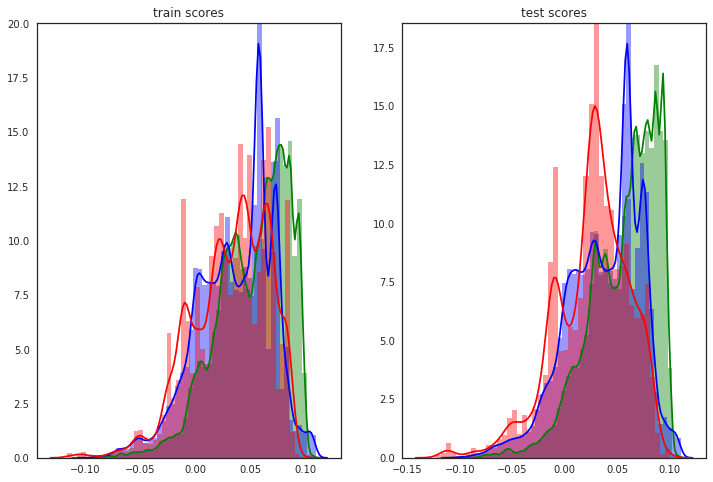

In [238]:
f, axes = plt.subplots(1, 2)
target_uniqs = [-1, 0, 1]
colors = ['g', 'b', 'r']
for tu, c in zip(target_uniqs, colors):
    sns.distplot(train_scores[ytrain[200000:] == tu], color=c, ax=axes[0])

for tu, c in zip(target_uniqs, colors):
    sns.distplot(test_scores[ytest == tu], color=c, ax=axes[1])
axes[0].set_title('train scores')
axes[1].set_title('test scores')

In [239]:
kek = PCA(n_components=50)

In [240]:
eknp_vals = kek.fit_transform(nndfs_ohe['P_EKNPCODE'].values[:train_size])

In [241]:
ekpn_test_vals = kek.transform(nndfs_ohe['P_EKNPCODE'].values[train_size:])

In [245]:
kek.explained_variance_

array([0.25411362, 0.13338385, 0.05733978, 0.04631922, 0.0377904 ,
       0.02819795, 0.02377735, 0.02255247, 0.02086262, 0.01957397,
       0.01881087, 0.0163716 , 0.013639  , 0.0115862 , 0.01110269,
       0.01065752, 0.00999408, 0.00950138, 0.00785909, 0.00675539,
       0.00611153, 0.00548646, 0.00495223, 0.00478461, 0.00467879,
       0.00452138, 0.00421203, 0.00353779, 0.00321689, 0.00306066,
       0.0025069 , 0.00223311, 0.00213416, 0.00203878, 0.00198872,
       0.00195026, 0.00174628, 0.00166634, 0.00152774, 0.00144184,
       0.0014104 , 0.00135746, 0.00131458, 0.00121034, 0.00106164,
       0.00100888, 0.00092609, 0.00087751, 0.00084628, 0.00082473])

In [246]:
kek.explained_variance_ratio_

array([0.29781351, 0.15632186, 0.06720049, 0.05428473, 0.04428921,
       0.03304715, 0.02786634, 0.02643081, 0.02445036, 0.0229401 ,
       0.02204577, 0.01918703, 0.0159845 , 0.01357868, 0.01301202,
       0.0124903 , 0.01171276, 0.01113533, 0.00921062, 0.00791711,
       0.00716253, 0.00642996, 0.00580387, 0.00560742, 0.0054834 ,
       0.00529892, 0.00493637, 0.00414618, 0.0037701 , 0.003587  ,
       0.00293801, 0.00261714, 0.00250118, 0.00238939, 0.00233072,
       0.00228565, 0.00204659, 0.0019529 , 0.00179046, 0.0016898 ,
       0.00165295, 0.00159091, 0.00154065, 0.00141848, 0.00124421,
       0.00118238, 0.00108536, 0.00102842, 0.00099181, 0.00096656])

In [250]:
len(joined_off_ops)

8222275

In [251]:
len(joined_off_ops)

8222275

In [254]:
joined_off_ops.ID.value_counts()

7089206    2
7101710    2
7093006    2
7106711    2
7101807    2
7076115    2
7104372    2
7081578    2
7103627    2
7098230    2
7083276    2
7094077    2
2313920    1
2125476    1
6497997    1
6317733    1
2100904    1
2305740    1
6293161    1
6489801    1
2109100    1
6301357    1
2150064    1
6506177    1
6342321    1
2297544    1
2158260    1
6350517    1
6309537    1
6514373    1
          ..
6952982    1
6871118    1
2756631    1
6977562    1
2781211    1
6969374    1
2773023    1
7059490    1
2863139    1
7051302    1
2854951    1
7075882    1
2879531    1
7067694    1
2871343    1
7026738    1
2830387    1
7018550    1
2822199    1
7043130    1
2846779    1
7034942    1
2838591    1
6862914    1
2666563    1
6854726    1
2658375    1
6879306    1
2682955    1
0          1
Name: ID, Length: 8222263, dtype: int64

Text(0.5,1,'test scores')

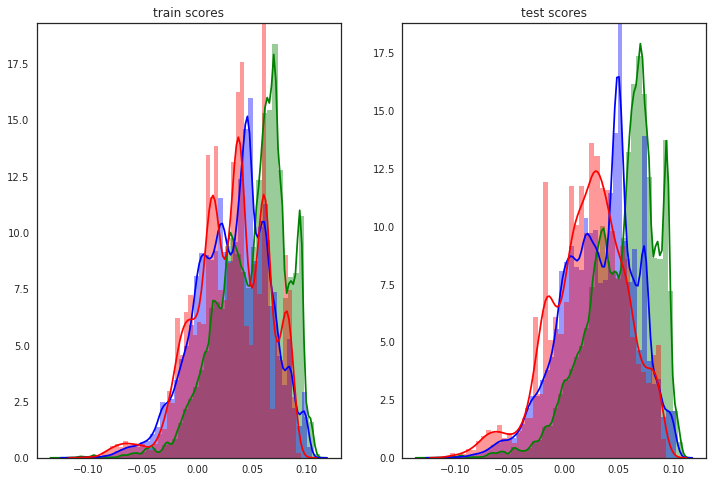

In [230]:
f, axes = plt.subplots(1, 2)
target_uniqs = [-1, 0, 1]
colors = ['g', 'b', 'r']
for tu, c in zip(target_uniqs, colors):
    sns.distplot(train_scores[ytrain == tu], color=c, ax=axes[0])

for tu, c in zip(target_uniqs, colors):
    sns.distplot(test_scores[ytest == tu], color=c, ax=axes[1])
axes[0].set_title('train scores')
axes[1].set_title('test scores')

In [219]:
nndf.columns

Index(['ID', 'P_ISSUEDBID', 'P_BRANCH', 'P_CURRENCYCODE', 'P_BASEAMOUNT',
       'P_EKNPCODE', 'P_DOCNUMBER', 'P_DOCCATEGORY', 'P_TOEXTRACTBOOL',
       'P_KFM_OPER_REASON', 'P_BS_OPER_TYPE', 'P_WAS_SEND',
       'P_COUNTRYCODE|sender', 'P_BANKCITY|sender', 'P_BANK|sender',
       'P_BANK_CLIENT|sender', 'P_CLIENT_TYPE|sender', 'P_COUNTRYCODE|owner',
       'P_BANKCITY|owner', 'P_BANK|owner', 'P_BANK_CLIENT|owner',
       'P_CLIENT_TYPE|owner', 'target', 'TIME_REG_DELTA|owner',
       'TIME_REG_DELTA|sender', 'links_input_owner', 'links_input_sender',
       'links_output_owner', 'links_output_sender'],
      dtype='object')

{'P_BANKCITY|owner':          P_BANKCITY|owner_0.0  P_BANKCITY|owner_3.0  P_BANKCITY|owner_4.0  \
 0                           0                     0                     0   
 1                           0                     0                     0   
 2                           0                     0                     0   
 3                           0                     0                     0   
 1252                        0                     0                     0   
 1253                        0                     0                     0   
 1254                        0                     0                     0   
 1255                        0                     0                     0   
 2723                        0                     0                     0   
 2724                        0                     0                     0   
 2725                        0                     0                     0   
 2726                        0              

In [180]:
%reset_selective -f nndf_ohe
nndf_ohe = pd.get_dummies(nndf, columns=columns_to_ohe, prefix=columns_to_ohe)

In [181]:
colnames_to_drop = [
    'ID',
    'target'
]

In [182]:
%reset_selective -f vals
%reset_selective -f targets

vals, targets = nndf_ohe.drop(colnames_to_drop, 1).values, nndf_ohe.target.values

In [184]:
vals.shape, targets.shape

((3275164, 1050), (3275164,))

In [187]:
vals, _vals = np.array(vals, dtype=np.float32), vals
%reset_selective -f _vals

In [188]:
train_rate = 0.6
train_size = int(train_rate * len(vals))
xtrain, ytrain, xtest, ytest = vals[:train_size], targets[:train_size], vals[train_size:], targets[train_size:]

In [190]:
list(nndf_ohe.columns)

['ID',
 'P_BASEAMOUNT',
 'target',
 'TIME_REG_DELTA|owner',
 'TIME_REG_DELTA|sender',
 'links_input_owner',
 'links_input_sender',
 'links_output_owner',
 'links_output_sender',
 'P_ISSUEDBID_1',
 'P_ISSUEDBID_2',
 'P_ISSUEDBID_3',
 'P_ISSUEDBID_4',
 'P_ISSUEDBID_5',
 'P_BRANCH_0',
 'P_BRANCH_3',
 'P_BRANCH_4',
 'P_BRANCH_5',
 'P_BRANCH_6',
 'P_BRANCH_7',
 'P_BRANCH_8',
 'P_BRANCH_9',
 'P_BRANCH_10',
 'P_BRANCH_11',
 'P_BRANCH_12',
 'P_BRANCH_13',
 'P_BRANCH_14',
 'P_BRANCH_15',
 'P_BRANCH_17',
 'P_BRANCH_19',
 'P_BRANCH_20',
 'P_BRANCH_0',
 'P_BRANCH_10',
 'P_BRANCH_11',
 'P_BRANCH_12',
 'P_BRANCH_13',
 'P_BRANCH_14',
 'P_BRANCH_15',
 'P_BRANCH_17',
 'P_BRANCH_19',
 'P_BRANCH_20',
 'P_BRANCH_3',
 'P_BRANCH_4',
 'P_BRANCH_5',
 'P_BRANCH_6',
 'P_BRANCH_7',
 'P_BRANCH_8',
 'P_BRANCH_9',
 'P_BRANCH_WAY 4',
 'P_CURRENCYCODE_36',
 'P_CURRENCYCODE_124',
 'P_CURRENCYCODE_156',
 'P_CURRENCYCODE_203',
 'P_CURRENCYCODE_356',
 'P_CURRENCYCODE_376',
 'P_CURRENCYCODE_398',
 'P_CURRENCYCODE_410',
 '

In [120]:
for colname in joined_direct_trans.columns:
    print(colname)

ID
P_ISSUEDBID
P_BANKOPERATIONID
P_BRANCH
P_CURRENCYCODE
P_OPERATIONDATETIME
P_BASEAMOUNT
P_CURRENCYAMOUNT
P_EKNPCODE
P_DOCNUMBER
P_DOCDATE
P_DOCCATEGORY
P_OPERATIONREASON
P_TOEXTRACTBOOL
P_DATE_INSERT
CHANGEDATE
P_KFM_OPER_REASON
P_BS_OPER_TYPE
P_ORIG_OPER_NUMBER
P_WAS_SEND
P_OPERATIONDATE
P_CLIENTID|sender
P_REGOPENDATE|sender
P_COUNTRYCODE|sender
P_BANKCITY|sender
P_BANK|sender
P_BANK_CLIENT|sender
P_CLIENT_TYPE|sender
P_CLIENTID|owner
P_REGOPENDATE|owner
P_COUNTRYCODE|owner
P_BANKCITY|owner
P_BANK|owner
P_BANK_CLIENT|owner
P_CLIENT_TYPE|owner
raw_id_sender
raw_id_owner
seconds_from_start
target
TIME_REG_DELTA|owner
TIME_REG_DELTA|sender


In [125]:
joined_direct_trans.P_DOCNUMBER.value_counts(dropna=False)

0000             264311
1                 42995
2                 27779
3                 24239
4                 21118
5                 18892
6                 17099
7                 15473
8                 13972
9                 12731
10                12107
11                11021
12                10140
13                 9414
14                 8857
15                 8247
16                 7524
17                 7050
18                 6556
19                 6192
20                 5789
21                 5492
22                 5179
23                 4907
24                 4698
25                 4405
26                 4140
27                 4015
28                 3795
29                 3618
                  ...  
278981371             1
6032695               1
285000104             1
522592436             1
276025049             1
276025050             1
278932791             1
282540467             1
284426449             1
1158510               1
286838778       

In [124]:
joined_direct_trans = joined_direct_trans.drop([colname for colname in joined_direct_trans.columns if 'beneficial' in colname], 1)

0.0006720032875385962

In [45]:
#graph_trans_df.to_csv('graph_trans_df.csv', index=False)

In [ ]:
%reset_selective -f seconds_passed_counter

seconds_passed_counter = defaultdict(lambda: len(seconds_passed_counter))

In [46]:
joined_spends = joined_off_ops[~joined_off_ops.raw_id_sender.isnull() & joined_off_ops.raw_id_owner.isnull() & joined_off_ops.raw_id_beneficial.isnull()]

In [47]:
len(joined_spends)

3833270

In [60]:
kek = joined_spends.P_OPERATIONREASON

In [48]:
joined_spends.columns

Index(['ID', 'P_ISSUEDBID', 'P_BANKOPERATIONID', 'P_BRANCH', 'P_CURRENCYCODE',
       'P_OPERATIONDATETIME', 'P_BASEAMOUNT', 'P_CURRENCYAMOUNT', 'P_EKNPCODE',
       'P_DOCNUMBER', 'P_DOCDATE', 'P_DOCCATEGORY', 'P_OPERATIONREASON',
       'P_TOEXTRACTBOOL', 'P_DATE_INSERT', 'CHANGEDATE', 'P_KFM_OPER_REASON',
       'P_BS_OPER_TYPE', 'P_ORIG_OPER_NUMBER', 'P_WAS_SEND', 'P_OPERATIONDATE',
       'P_CLIENTID|sender', 'P_REGOPENDATE|sender', 'P_COUNTRYCODE|sender',
       'P_BANKCITY|sender', 'P_BANK|sender', 'P_BANK_CLIENT|sender',
       'P_CLIENT_TYPE|sender', 'P_CLIENTID|owner', 'P_REGOPENDATE|owner',
       'P_COUNTRYCODE|owner', 'P_BANKCITY|owner', 'P_BANK|owner',
       'P_BANK_CLIENT|owner', 'P_CLIENT_TYPE|owner', 'P_CLIENTID|beneficial',
       'P_REGOPENDATE|beneficial', 'P_COUNTRYCODE|beneficial',
       'P_BANKCITY|beneficial', 'P_BANK|beneficial',
       'P_BANK_CLIENT|beneficial', 'P_CLIENT_TYPE|beneficial', 'raw_id_sender',
       'raw_id_owner', 'raw_id_beneficial', 'second

In [88]:
def simplify_reason(s):
    s = re.sub('KZ\d+KZT[A-Z\d]+', '{#KZ-KZT-ACC}', s)
    s = re.sub('KZ\d+A\d+', '{#KZ-CARD-ACC}', s)
    s = re.sub('<<\d+\.\d+\s([A-Z]+)', r'<<{#amount} \1>>', s)
    s = re.sub('[A-Z_]+\sЗ?PHONE=\d+;', '{#operator_name} PHONE={#phone_num};', s)
    s = re.sub('\(ОПЛАТА УСЛУГ СОТОВОЙ СВЯЗИ [A-Za-z]+\)', '(ОПЛАТА УСЛУГ СОТОВОЙ СВЯЗИ {#operator_name})', s)
    return s

pek = kek[::10].map(simplify_reason)

In [89]:
print(len(pek))
print(pek.value_counts(dropna=False))

383327
ОПЛАТА УСЛУГ ЧЕРЕЗ SMARTBANK; DEFAULT; ALMATY; KAZ ;KAZAKHSTAN ;                                                                                                            26744
КНП_324 SM.BANK ПЕР.СО СЧЕТА {#KZ-KZT-ACC} НА КАРТ.СЧЕТ {#KZ-CARD-ACC}                                                                                                      15101
ОПЛАТА УСЛУГ ЧЕРЕЗ SMARTBANK; DEFAULT; LOCAL; KAZ ;KAZAKHSTAN ;                                                                                                              6166
SHOP "NAKHODKA" POS02021; ПОКУПКА (ОПЕРАЦИИ ЧЕРЕЗ ПОС ТЕРМИНАЛ В ТОРГОВЫХ СЕТЯХ); RUDNY; KAZ ;KAZAKHSTAN ;                                                                   5976
STOLOVAYA 24-2 POS02039; ПОКУПКА (ОПЕРАЦИИ ЧЕРЕЗ ПОС ТЕРМИНАЛ В ТОРГОВЫХ СЕТЯХ); RUDNY; KAZ ;KAZAKHSTAN ;                                                                    5605
TOO SERVIS POS02033; ПОКУПКА (ОПЕРАЦИИ ЧЕРЕЗ ПОС ТЕРМИНАЛ В ТОРГОВЫХ СЕТЯХ); RUDNY; KAZ ;KAZAKHSTAN ;  

In [70]:
s = 'КНП_324 SM.BANK ПЕР. СО СЧЕТА {#KZ-KZT-ACC} НА СЧЕТ {#KZ-KZT-ACC} <<239.00 KZT>> '

In [74]:
re.sub('<<\d+\.\d+\s([A-Z]+)', r'<<{#amount} \1>>', s)

'КНП_324 SM.BANK ПЕР. СО СЧЕТА {#KZ-KZT-ACC} НА СЧЕТ {#KZ-KZT-ACC} <<{#amount} KZT>>>> '

In [91]:
joined_spends.target.value_counts()

-1    3742898
 0      87286
 1       3086
Name: target, dtype: int64

In [92]:
joined_off_ops.target.value_counts()

-1    7823750
 0     365962
 1      32563
Name: target, dtype: int64

In [93]:
joined_direct_trans = joined_off_ops[~joined_off_ops.raw_id_sender.isnull() & ~joined_off_ops.raw_id_owner.isnull() & joined_off_ops.raw_id_beneficial.isnull()]
joined_undirect_trans = joined_off_ops[~joined_off_ops.raw_id_sender.isnull() & joined_off_ops.raw_id_owner.isnull() & ~joined_off_ops.raw_id_beneficial.isnull()]
joined_messy_trans = joined_off_ops[~joined_off_ops.raw_id_sender.isnull() & ~joined_off_ops.raw_id_owner.isnull() & ~joined_off_ops.raw_id_beneficial.isnull()]

In [94]:
joined_direct_trans.target.value_counts()

-1    2986847
 0     260198
 1      28119
Name: target, dtype: int64

In [95]:
joined_undirect_trans.target.value_counts()

-1    18172
 0      172
 1        4
Name: target, dtype: int64

In [96]:
joined_messy_trans.target.value_counts()

-1    136
 0      5
Name: target, dtype: int64

In [99]:
joined_clear_income = joined_off_ops[joined_off_ops.raw_id_sender.isnull() & ~joined_off_ops.raw_id_owner.isnull() & joined_off_ops.raw_id_beneficial.isnull()]

In [100]:
joined_clear_income.target.value_counts()

-1    1066247
 0      18096
 1       1351
Name: target, dtype: int64